<a href="https://colab.research.google.com/github/Sarik123-long/Brain-tumor-detection/blob/main/brain_tumor_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()  # Upload the zip file

Saving archive (15).zip to archive (15).zip


In [2]:
import zipfile
import os

# Get the actual uploaded file name from the 'uploaded' dictionary
# Assuming only one file was uploaded in the previous cell
zip_path = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("brain_tumor_dataset")

# Check extracted folders
os.listdir("brain_tumor_dataset")

['yes', 'brain_tumor_dataset', 'no']

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
IMG_SIZE = 224
data = []
labels = []

# Corrected the path to use the already extracted dataset
categories = os.listdir("brain_tumor_dataset")  # should be ['yes', 'no']
for category in categories:
    # Corrected the path to use the already extracted dataset
    path = os.path.join("brain_tumor_dataset", category)
    # Ensure that the path is a directory before listing its contents
    if os.path.isdir(path):
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            # Ensure that the path is a file before trying to read it
            if os.path.isfile(img_path):
                try:
                    img_array = cv2.imread(img_path)
                    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    data.append(img_array)
                    labels.append(class_num)
                except Exception as e: # Added exception handling for image reading
                    print(f"Error reading image {img_path}: {e}")
                    continue # Skip to the next image if reading fails

X = np.array(data) / 255.0
y = np.array(labels)

print(f"Loaded {len(data)} images with labels.") # Added print statement to confirm loading

Loaded 253 images with labels.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
es = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("brain_tumor_model.keras", monitor='val_accuracy', save_best_only=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[es, checkpoint]
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.2118 - loss: 0.5000 - val_accuracy: 0.1961 - val_loss: -0.0982
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.2009 - loss: -0.0853 - val_accuracy: 0.3137 - val_loss: -0.6250
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2226 - loss: -0.4387 - val_accuracy: 0.2353 - val_loss: -1.1482
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.2244 - loss: -0.9776 - val_accuracy: 0.2745 - val_loss: -1.6220
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.2530 - loss: -1.5478 - val_accuracy: 0.3333 - val_loss: -2.1480
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.2889 - loss: -1.2715 - val_accuracy: 0.2941 - val_loss: -2.7688
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.2013 - loss: -2.0084 - val_accuracy: 0.2941 - val_loss: -3.3447
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.2433 - loss: -3.3221 - val_accuracy: 0.3137 - val_loss: -

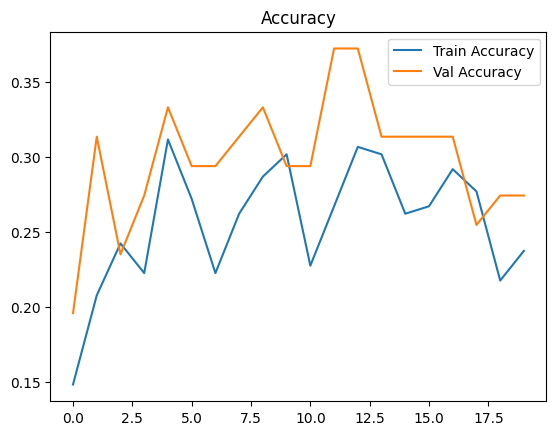

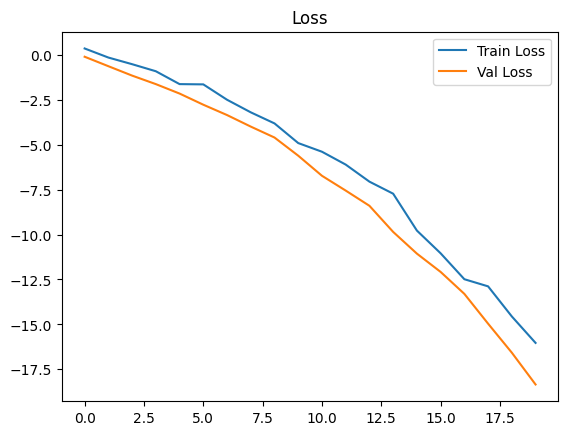

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.45      0.62        31
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        20

    accuracy                           0.27        51
   macro avg       0.33      0.15      0.21        51
weighted avg       0.61      0.27      0.38        51



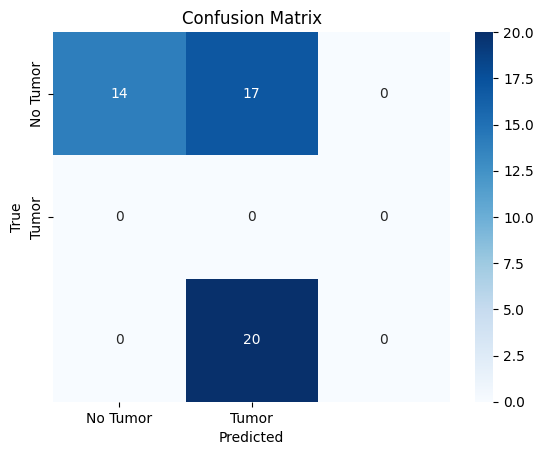

In [10]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


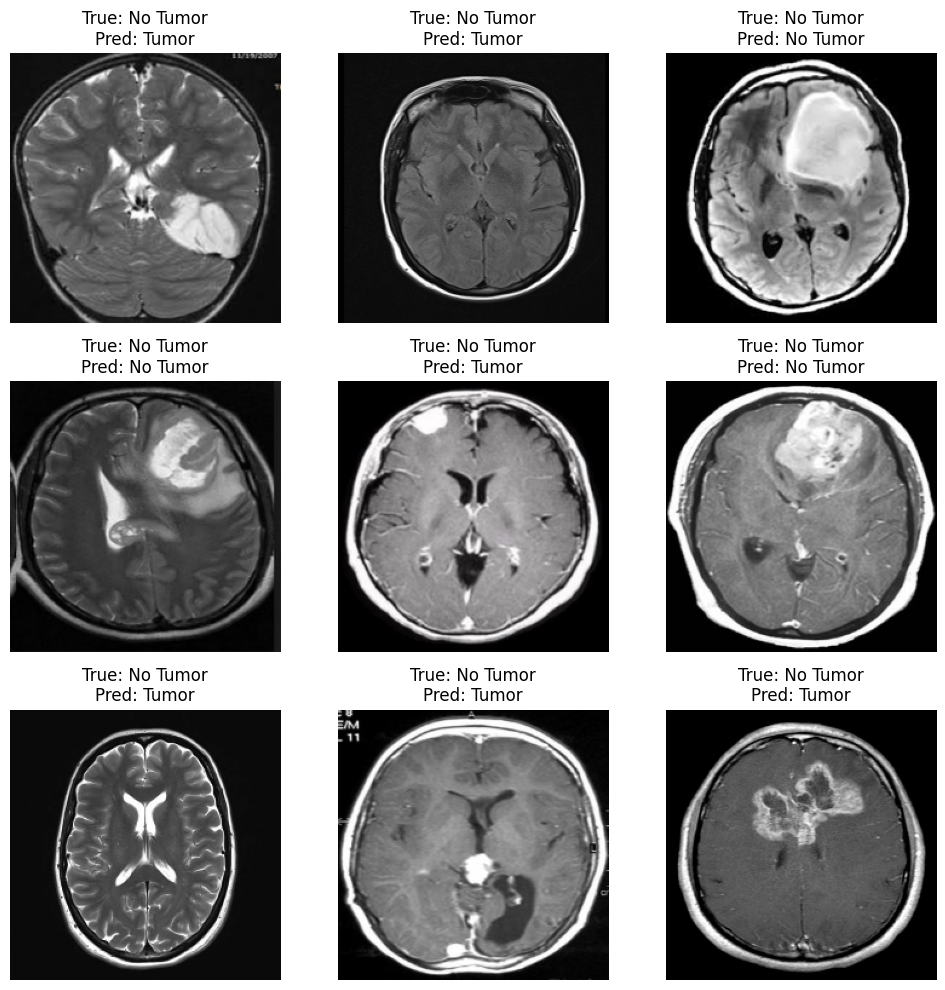

In [11]:
indices = np.random.choice(len(X_test), 9)
plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx])
    true_label = 'Tumor' if y_test[idx] == 1 else 'No Tumor'
    pred_label = 'Tumor' if y_pred[idx] == 1 else 'No Tumor'
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [12]:
!pip install gradio tensorflow --quiet


In [17]:
import gradio as gr
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import os

In [19]:
IMG_SIZE = 224

def build_model():
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# For demonstration, load a pre-trained model
model_path = "/content/brain_tumor_model.keras"  # Update with your model path
if os.path.exists(model_path):
    model = load_model(model_path)
else:
    model = build_model()
    print("Model not found. Train the model or upload one.")


In [20]:
#Gradio prediction function
def predict_brain_tumor(image):
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)[0][0]
    label = "Tumor" if prediction > 0.5 else "No Tumor"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return f"{label} ({confidence*100:.2f}%)"


In [21]:
#Create Gradio Interface
interface = gr.Interface(
    fn=predict_brain_tumor,
    inputs=gr.Image(type="numpy", label="Upload Brain MRI"),
    outputs=gr.Text(label="Prediction"),
    title="🧠 Brain Tumor Detection",
    description="Upload an MRI scan to detect presence of brain tumor using MobileNetV2."
)

interface.launch(debug=False)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3b4be401fc3fa11593.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
